# Gaussian Kernel Parameters


## Library and dataset import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
%config Completer.use_jedi = False
session = tf.Session()

In [2]:
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])

class1_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i] == 1]
class1_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i] == 1]

class2_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i] == -1]
class2_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i] == -1]


### Variable creation

In [3]:
batch_size = 150
x_data = tf.placeholder(shape = [None, 2], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)

prediction_grid = tf.placeholder(shape = [None, 2], dtype = tf.float32)

b = tf.Variable(tf.random_normal(shape = [1, batch_size]))

### Gaussian kernel

In [26]:
gamma = tf.constant(-5.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1, 1])
sq_dist = tf.add(tf.subtract(dist, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dist)))

### SVM general solution

In [14]:
first_sum = tf.reduce_sum(b)
b_vect_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))

second_sum = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vect_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_sum, second_sum))

### Prediction Kernel

In [15]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1, 1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1, 1])

pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

### Algorithm train

In [21]:
learning_rate = 0.01
my_opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_step = my_opt.minimize(loss)

### Variable initilization

In [22]:
init = tf.global_variables_initializer()
session.run(init)

## Model training

In [23]:
loss_vect = []
batch_acc = []

for i in range(400):
    rand_idx = np.random.choice(len(x_vals), size = batch_size)
    rand_x = x_vals[rand_idx]
    rand_y = np.transpose([y_vals[rand_idx]])
    session.run(train_step, feed_dict= {x_data: rand_x,
                                        y_target: rand_y})
    temp_loss = session.run(loss, feed_dict= {x_data: rand_x,
                                              y_target: rand_y})
    loss_vect.append(temp_loss)
    
    temp_acc = session.run(accuracy, feed_dict= {x_data: rand_x,
                                                 y_target: rand_y,
                                                 prediction_grid: rand_x})
    batch_acc.append(temp_acc)
    
    if (i+1)%50 == 0:
        print('Step #'+str(i+1)+
              'Loss = '+str(temp_loss)+
              'Accuracy = '+str(temp_acc))

Step #50Loss = 15.709322Accuracy = 0.68666667
Step #100Loss = 2.955657Accuracy = 0.97333336
Step #150Loss = -0.14957333Accuracy = 0.8333333
Step #200Loss = -1.8952826Accuracy = 0.98
Step #250Loss = -2.1500018Accuracy = 0.9866667
Step #300Loss = -2.0722756Accuracy = 0.99333334
Step #350Loss = -2.018245Accuracy = 0.98
Step #400Loss = -1.952348Accuracy = 0.9866667


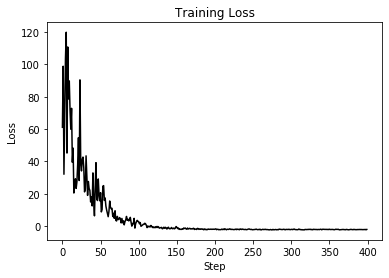

In [24]:
plt.plot(loss_vect, 'k-')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

### Result visualization

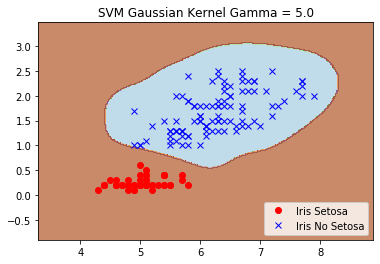

In [25]:
x_min, x_max = x_vals[:, 0].min()-1, x_vals[:, 0].max()+1
y_min, y_max = x_vals[:, 1].min()-1, x_vals[:, 1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]

[grid_predictions] = session.run(prediction, feed_dict={x_data: x_vals,
                                                       y_target: np.transpose([y_vals]),
                                                       prediction_grid: grid_points})

grid_predictions = grid_predictions.reshape(xx.shape)


x_min, x_max = x_vals[:,0].min()-1, x_vals[:,0].max()+1
y_min, y_max = x_vals[:,1].min()-1, x_vals[:,1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]

[grid_predictions] = session.run(prediction, feed_dict={x_data: x_vals,
                                                   y_target: np.transpose([y_vals]),
                                                   prediction_grid: grid_points})

grid_predictions = grid_predictions.reshape(xx.shape)

plt.contourf(xx, yy, grid_predictions, cmap = plt.cm.Paired, alpha = 0.7)
plt.plot(class1_x, class1_y, 'ro', label = 'Iris Setosa')
plt.plot(class2_x, class2_y, 'bx', label = 'Iris No Setosa')
plt.legend(loc = 'lower right')

plt.title('SVM Gaussian Kernel Gamma = '+str(-session.run(gamma)))
plt.show()